## Comparison of 201905 Model Phytoplankton to HPLC Phytoplankton Abundances from Nina Nemcek

In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

Note: crypto+hapto+prasino grouping was actually determined based on comparisons to 201812 model run

## Load data and matched model output

In [2]:
modSourceDir= '/results2/SalishSea/nowcast-green.201905/'
modver='201905'
Chl_N=1.8 # Chl:N ratio
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [6]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [7]:
if os.path.isfile('matched_'+modver+datestr+'_NewALLO.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'_NewALLO.pkl', 'rb' ) )
    print('matched_'+modver+datestr+'_NewALLO.pkl')
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018_NewALLO.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    #df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    #df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    #df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    #df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'].values,df['Lat'].values),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'].values,df['Lat'].values),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'].values,df['p'].values,df['Lon'].values,df['Lat'].values)
    df['CT']=gsw.CT_from_t(df['SA'].values,df['Temperature'].values,df['p'].values)
    df.rename({'TchlA':'TchlA (ug/L)','Raphido':'Raphidophytes','Dinoflagellates-1':'Dinoflagellates',
            'Dictyo':'Dictyochophytes'},axis=1, inplace=True, errors='raise')
    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'_NewALLO.pkl','wb') as f:
        pickle.dump(data,f)

matched_201905_20150101_20181231_NewALLO.pkl


In [8]:
data.keys()

Index(['FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat', 'Lon',
       'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Diatoms-1',
       'Diatoms-2', 'Prasinophytes', 'Cryptophytes', 'Dinoflagellates',
       'Haptophytes', 'Dictyochophytes', 'Raphidophytes', 'Cyanobacteria',
       'TchlA (ug/L)', 'Pressure [decibar]', 'Transmissivity [*/metre]',
       'PAR [uE/m^2/sec]', 'PAR:Reference [uE/m^2/sec]',
       'Oxygen:Dissolved:SBE [mL/L]', 'Oxygen:Dissolved:SBE [umol/kg]',
       'Chlorophyll:Extracted [mg/m^3]', 'Phaeo-Pigment:Extracted [mg/m^3]',
       'Nitrate_plus_Nitrite [umol/L]', 'Silicate [umol/L]',
       'Phosphate [umol/L]', 'Bottle_Number', 'Oxygen:Dissolved [mL/L]',
       'Oxygen:Dissol

In [9]:
data['LOC:STATION'].unique()

array(['SI', '59', '102', '75', '72', '69', 'ADCP', '65', '63', '62',
       '56', '46', '42', '39', 'GE01', '27', '2', '3', 'BS', '6', '9',
       '12', '14', '16', '22', '11', 'CPF2', 'CPF1', '24', '28', '38',
       '41', 'BS17', '19', 'GEO1', 'BS11', 'SC-04', '66', 'BI2', 'JF2',
       'HARO59', 'SI03', '15', 'SC04', '40', 'qu39', 'Van1', 'BS-11',
       'adcp', 'QU39', 'CPF-2', 'CPF-1', 'Haro 59', 'BS2', 'IS-2', 'PEN1',
       'PEN2', 'PEN3'], dtype=object)

In [10]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [11]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [12]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

## Determine which HPLC groups have the highest biomass

In [13]:
data['Diatoms-1'].mean() ## Highest biomass

2.1757399193548412

In [14]:
data['Diatoms-2'].mean() ## include

0.3043850806451614

In [15]:
data['Cyanobacteria'].mean() ## exclude due to low biomass

0.03817540322580645

In [16]:
data['Cryptophytes'].mean() ## include

0.4574556451612899

In [17]:
data['Prasinophytes'].mean() ## include

0.21607862903225808

In [18]:
data['Haptophytes'].mean() ## include

0.23795766129032253

In [19]:
data['Dictyochophytes'].mean() ## exclude due to low biomass

0.039802419354838664

In [20]:
data['Dinoflagellates'].mean() # exclude due to low biomass

0.10347580645161288

In [21]:
data['Raphidophytes'].mean() ## Include

0.40433064516129036

In [22]:
data['Month']=[ii.month for ii in data['dtUTC']]

In [23]:
monthlymean=data.groupby(['Month']).mean()

In [24]:
monthlymean['Diatoms-1']

Month
2     0.120424
3     3.233714
4     4.943088
5     2.529966
6     2.168265
7     0.551176
8     2.249000
9     0.941815
10    1.593719
11    0.785317
Name: Diatoms-1, dtype: float64

In [25]:
monthlymean['HPLCDiatoms']=(monthlymean['Diatoms-1']+monthlymean['Raphidophytes']+monthlymean['Diatoms-2'])

In [26]:
monthlymean['HPLCFlag']=(monthlymean['Cryptophytes']+monthlymean['Haptophytes']+monthlymean['Raphidophytes'])

In [27]:
monthlymean['HPLCDiatoms']

Month
2     0.337182
3     3.697286
4     5.422284
5     3.205103
6     3.780675
7     0.780706
8     4.946000
9     1.361207
10    2.194649
11    0.897024
Name: HPLCDiatoms, dtype: float64

In [28]:
monthlysem=logt(data.groupby(['Month']).sem())

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1510: RuntimeWarning: divide by zero encountered in true_divide
  result.iloc[:, cols].values / np.sqrt(self.count().iloc[:, cols]).values


In [29]:
monthlymean['L10mod_diatoms']=logt(monthlymean['mod_diatoms']*Chl_N)
monthlymean['L10mod_flagellates']=logt(monthlymean['mod_flagellates']*Chl_N)
monthlymean['L10Diatoms-1']=logt(monthlymean['Diatoms-1'])
monthlymean['L10Diatoms-2']=logt(monthlymean['Diatoms-2'])
monthlymean['L10Cryptophytes']=logt(monthlymean['Cryptophytes'])
monthlymean['L10Prasinophytes']=logt(monthlymean['Prasinophytes'])
monthlymean['L10Haptophytes']=logt(monthlymean['Haptophytes'])
monthlymean['L10Raphidophytes']=logt(monthlymean['Raphidophytes'])
monthlymean['L10TotalChla']=logt(monthlymean['TchlA (ug/L)'])

monthlymean['L10HPLCDiatoms']=logt(monthlymean['HPLCDiatoms'])
monthlymean['L10HPLCFlag']=logt(monthlymean['HPLCFlag'])

In [30]:
monthlymean['L10mod_diatoms']

Month
2    -2.432694
3    -1.367311
4    -0.199868
5     0.144985
6    -0.174303
7    -0.161647
8    -0.892479
9    -1.197468
10   -1.436750
11   -1.700827
Name: L10mod_diatoms, dtype: float64

In [31]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

## Model vs Obs Plots for various model-obs groups

### Correlation Coefficient Matrix

In [32]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

In [33]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.129174,-0.044520,-0.104293,-0.155529,-0.089528,-0.038014,0.068507,0.186019,0.986013,-0.143394,0.799078,0.329545,-0.107524,0.086555,0.240522
Diatoms-2,0.129174,1.000000,0.087055,0.065789,0.041872,0.045439,0.204256,0.030159,0.089479,0.292639,0.067138,0.278908,0.068727,-0.136186,-0.003254,-0.009364
Cyanobacteria,-0.044520,0.087055,1.000000,0.455047,0.673585,0.265069,0.134517,0.111427,0.471045,-0.028299,0.565312,0.323326,-0.064953,0.271249,0.028373,0.083302
Cryptophytes,-0.104293,0.065789,0.455047,1.000000,0.629727,0.330846,0.059123,0.105006,0.151756,-0.089512,0.850031,0.145622,0.107619,0.283430,0.018542,0.238735
Prasinophytes,-0.155529,0.041872,0.673585,0.629727,1.000000,0.273744,0.115485,0.043839,0.193154,-0.142939,0.760689,0.115373,-0.114043,0.288055,-0.032531,0.043383
Haptophytes,-0.089528,0.045439,0.265069,0.330846,0.273744,1.000000,0.028364,-0.005455,-0.014300,-0.078695,0.718854,0.040637,-0.024129,0.309359,0.041182,0.139303
Dictyochophytes,-0.038014,0.204256,0.134517,0.059123,0.115485,0.028364,1.000000,0.070478,0.073749,-0.002326,0.079637,0.084752,-0.061454,0.083663,-0.033596,-0.014315
Dinoflagellates,0.068507,0.030159,0.111427,0.105006,0.043839,-0.005455,0.070478,1.000000,0.224567,0.071130,0.063264,0.247006,0.051962,0.131246,0.028659,0.114278
Raphidophytes,0.186019,0.089479,0.471045,0.151756,0.193154,-0.014300,0.073749,0.224567,1.000000,0.194417,0.130332,0.697246,0.198755,-0.038571,0.003086,0.153761
DD,0.986013,0.292639,-0.028299,-0.089512,-0.142939,-0.078695,-0.002326,0.071130,0.194417,1.000000,-0.126991,0.817431,0.329332,-0.126575,0.082919,0.230362


##### Strongest correlations:
Model diatoms and:
- Total chla: 0.343112
- Diatoms-1: 0.329545
- Diatoms-1+Diatoms-2: 0.329332

Model flagellates and:
- crypto+hapto+prasino: 0.377130
- haptophytes: 0.309359
- prasinophytes: 0.288055
- cryptophytes: 0.283430
- cyanobacteria: 0.271249 (but remember that cyanobacteria abundances are low)

### Variance-Covariance Matrix

In [34]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.030227,0.383433,-0.014114,-0.180451,-0.176579,-0.147258,-0.029133,0.111324,2.290018,17.413661,-0.504288,19.195920,2.849766,-0.540311,0.080426,2.389881
Diatoms-2,0.383433,0.517381,0.004810,0.019841,0.008286,0.013027,0.027284,0.008542,0.191999,0.900814,0.041154,1.167819,0.103589,-0.119279,-0.000527,-0.016217
Cyanobacteria,-0.014114,0.004810,0.005901,0.014656,0.014236,0.008116,0.001919,0.003371,0.107947,-0.009303,0.037008,0.144586,-0.010456,0.025373,0.000491,0.015408
Cryptophytes,-0.180451,0.019841,0.014656,0.175789,0.072638,0.055288,0.004603,0.017336,0.189807,-0.160610,0.303715,0.355411,0.094552,0.144700,0.001750,0.241003
Prasinophytes,-0.176579,0.008286,0.014236,0.072638,0.075690,0.030017,0.005900,0.004749,0.158524,-0.168293,0.178345,0.184770,-0.065746,0.096499,-0.002015,0.028737
Haptophytes,-0.147258,0.013027,0.008116,0.055288,0.030017,0.158861,0.002099,-0.000856,-0.017002,-0.134231,0.244167,0.094285,-0.020153,0.150141,0.003696,0.133684
Dictyochophytes,-0.029133,0.027284,0.001919,0.004603,0.005900,0.002099,0.034487,0.005154,0.040856,-0.001849,0.012603,0.091620,-0.023915,0.018919,-0.001405,-0.006401
Dinoflagellates,0.111324,0.008542,0.003371,0.017336,0.004749,-0.000856,0.005154,0.155056,0.263792,0.119866,0.021229,0.566188,0.042876,0.062930,0.002541,0.108347
Raphidophytes,2.290018,0.191999,0.107947,0.189807,0.158524,-0.017002,0.040856,0.263792,8.899071,2.482017,0.331329,12.107873,1.242441,-0.140106,0.002073,1.104408
DD,17.413661,0.900814,-0.009303,-0.160610,-0.168293,-0.134231,-0.001849,0.119866,2.482017,18.314475,-0.463135,20.363739,2.953355,-0.659590,0.079900,2.373664


##### largest covariances:
Model diatoms and:
- TChlA: 4.185330
- Diatoms-1+Diatoms-2: 2.953355
- Diatoms-1: 2.849766
- Raphidophytes: 1.242441

Model flagellates and:
- crypto+hapto+prasino: 0.391340
- haptophytes: 0.150141
- cryptophytes: 0.144700

### Corr Coeff matrix with log transformed values:

In [35]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.158963,-0.183906,-0.200691,-0.330748,-0.178564,-0.022753,0.257098,-0.044532,-0.240631,0.620741,0.381332,-0.121685,0.098088,0.158253
Diatoms-2,0.158963,1.000000,-0.070727,-0.017724,-0.081120,-0.206987,0.260879,0.110120,-0.069205,-0.095680,0.117311,-0.054775,-0.295843,-0.045642,-0.179840
Cyanobacteria,-0.183906,-0.070727,1.000000,0.308677,0.391266,0.322685,0.341206,0.001006,0.323720,0.387215,0.114417,-0.177385,0.423884,0.162395,0.141110
Cryptophytes,-0.200691,-0.017724,0.308677,1.000000,0.705089,0.328445,0.337350,0.256664,0.383761,0.872284,0.077971,-0.057914,0.290401,0.036045,0.120324
Prasinophytes,-0.330748,-0.081120,0.391266,0.705089,1.000000,0.299601,0.401870,0.140807,0.462423,0.698793,-0.023818,-0.289977,0.340049,0.021557,0.023916
Haptophytes,-0.178564,-0.206987,0.322685,0.328445,0.299601,1.000000,0.204290,0.047297,0.189056,0.576696,0.063931,-0.102367,0.250856,0.062734,0.100466
Dictyochophytes,-0.022753,0.260879,0.341206,0.337350,0.401870,0.204290,1.000000,0.267118,0.337107,0.328808,0.131390,-0.229019,0.120689,-0.086112,-0.078591
Dinoflagellates,0.257098,0.110120,0.001006,0.256664,0.140807,0.047297,0.267118,1.000000,0.354625,0.246911,0.416244,0.176141,0.109616,0.039243,0.135781
Raphidophytes,-0.044532,-0.069205,0.323720,0.383761,0.462423,0.189056,0.337107,0.354625,1.000000,0.370869,0.227029,-0.102750,0.287205,0.039728,0.080884
CPH,-0.240631,-0.095680,0.387215,0.872284,0.698793,0.576696,0.328808,0.246911,0.370869,1.000000,0.125576,-0.084175,0.324159,0.059914,0.130502


### Cov matrix with log transformed values:

In [36]:

dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.707049,0.223426,-0.191222,-0.156507,-0.337293,-0.224417,-0.022976,0.263191,-0.054699,-0.169667,0.364806,0.476603,-0.084867,0.038920,0.104432
Diatoms-2,0.223426,1.157251,-0.060550,-0.011380,-0.068113,-0.214188,0.216906,0.092818,-0.069990,-0.055547,0.056765,-0.056367,-0.169885,-0.014911,-0.097714
Cyanobacteria,-0.191222,-0.060550,0.633347,0.146625,0.243042,0.247024,0.209872,0.000628,0.242199,0.166302,0.040958,-0.135042,0.180073,0.039249,0.056720
Cryptophytes,-0.156507,-0.011380,0.146625,0.356259,0.328485,0.188575,0.155626,0.120032,0.215341,0.280974,0.020934,-0.033067,0.092525,0.006534,0.036274
Prasinophytes,-0.337293,-0.068113,0.243042,0.328485,0.609223,0.224942,0.242433,0.086112,0.339321,0.294348,-0.008362,-0.216512,0.141680,0.005110,0.009428
Haptophytes,-0.224417,-0.214188,0.247024,0.188575,0.224942,0.925289,0.151881,0.035647,0.170967,0.299372,0.027662,-0.094195,0.128808,0.018326,0.048811
Dictyochophytes,-0.022976,0.216906,0.209872,0.155626,0.242433,0.151881,0.597360,0.161760,0.244945,0.137147,0.045678,-0.169324,0.049793,-0.020213,-0.030679
Dinoflagellates,0.263191,0.092818,0.000628,0.120032,0.086112,0.035647,0.161760,0.613904,0.261217,0.104403,0.146699,0.132020,0.045846,0.009338,0.053734
Raphidophytes,-0.054699,-0.069990,0.242199,0.215341,0.339321,0.170967,0.244945,0.261217,0.883823,0.188160,0.096005,-0.092404,0.144130,0.011343,0.038407
CPH,-0.169667,-0.055547,0.166302,0.280974,0.294348,0.299372,0.137147,0.104403,0.188160,0.291239,0.030483,-0.043455,0.093382,0.009820,0.035571


### Individual phytoplankton groups compared to  model groups (1:1 correspondence not expected)

Text(0.001584893192461114, 10, 'r = 0.33')

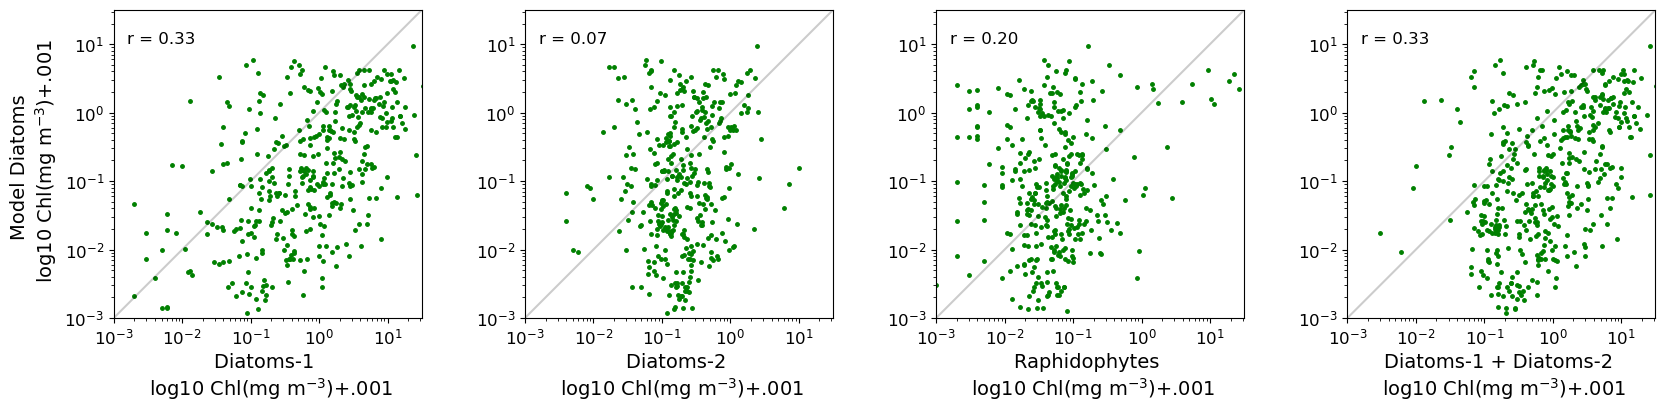

In [37]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.3)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot((data['Diatoms-1']),(data['mod_diatoms']),'g.',ms=5)
ax[0].set_ylabel('Model Diatoms \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_xlabel('Diatoms-1 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_title('')
ax[0].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[0].set_xlim((10**-3,10**1.5))
ax[0].set_ylim((10**-3,10**1.5))
ax[0].set_aspect(1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].text(10**-2.8,10**1, 'r = 0.33', fontsize=12,  color='k')

ax[1].plot((data['Diatoms-2']),(data['mod_diatoms']),'g.',ms=5)
ax[1].set_ylabel('')
ax[1].set_xlabel('Diatoms-2 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[1].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[1].set_xlim((10**-3,10**1.5))
ax[1].set_ylim((10**-3,10**1.5))
ax[1].set_aspect(1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[1].text(10**-2.8,10**1, 'r = 0.07', fontsize=12,  color='k')

ax[2].plot((data['Raphidophytes']),(data['mod_diatoms']),'g.',ms=5)
ax[2].set_ylabel('')
ax[2].set_xlabel('Raphidophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[2].set_title('')
ax[2].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[2].set_xlim((10**-3,10**1.5))
ax[2].set_ylim((10**-3,10**1.5))
ax[2].set_aspect(1)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].xaxis.set_tick_params(labelsize=12)
ax[2].yaxis.set_tick_params(labelsize=12)
ax[2].text(10**-2.8,10**1, 'r = 0.20', fontsize=12,  color='k')

ax[3].plot((data['Diatoms-1']+data['Diatoms-2']),(data['mod_diatoms']),'g.',ms=5)
ax[3].set_ylabel('')
ax[3].set_xlabel('Diatoms-1 + Diatoms-2 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[3].set_title('')
ax[3].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[3].set_xlim((10**-3,10**1.5))
ax[3].set_ylim((10**-3,10**1.5))
ax[3].set_aspect(1)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].xaxis.set_tick_params(labelsize=12)
ax[3].yaxis.set_tick_params(labelsize=12)
ax[3].text(10**-2.8,10**1, 'r = 0.33', fontsize=12,  color='k')

Text(0.001584893192461114, 10, 'r = 0.38')

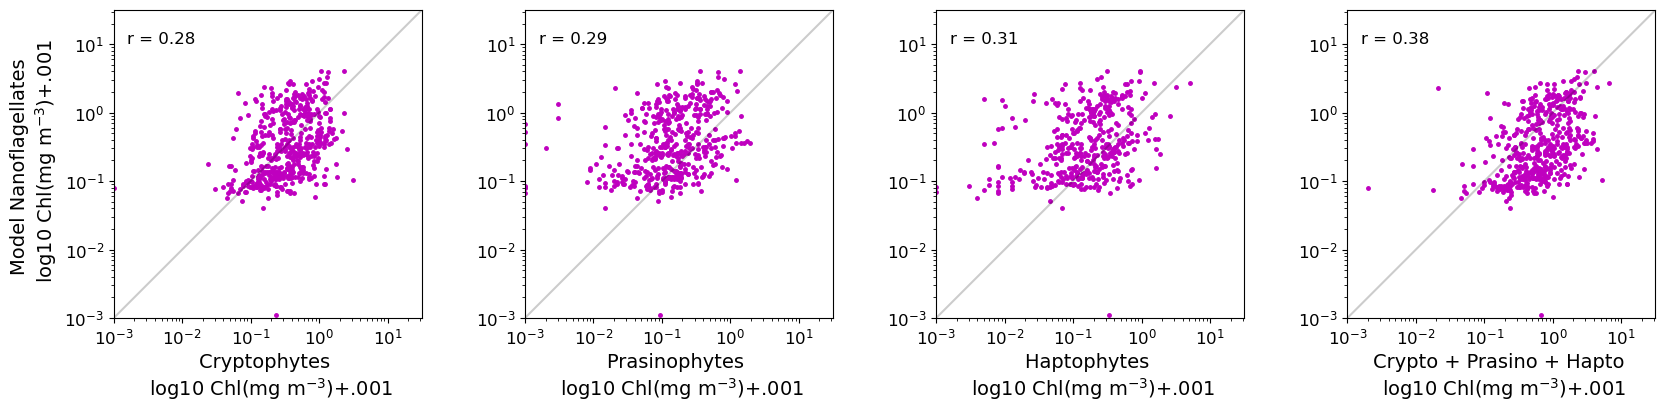

In [38]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.3)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot((data['Cryptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[0].set_ylabel('Model Nanoflagellates \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_xlabel('Cryptophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_title('')
ax[0].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[0].set_xlim((10**-3,10**1.5))
ax[0].set_ylim((10**-3,10**1.5))
ax[0].set_aspect(1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].text(10**-2.8,10**1, 'r = 0.28', fontsize=12,  color='k')

ax[1].plot((data['Prasinophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[1].set_ylabel('')
ax[1].set_xlabel('Prasinophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[1].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[1].set_xlim((10**-3,10**1.5))
ax[1].set_ylim((10**-3,10**1.5))
ax[1].set_aspect(1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[1].text(10**-2.8,10**1, 'r = 0.29', fontsize=12,  color='k')

ax[2].plot((data['Haptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[2].set_ylabel('')
ax[2].set_xlabel('Haptophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[2].set_title('')
ax[2].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[2].set_xlim((10**-3,10**1.5))
ax[2].set_ylim((10**-3,10**1.5))
ax[2].set_aspect(1)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].xaxis.set_tick_params(labelsize=12)
ax[2].yaxis.set_tick_params(labelsize=12)
ax[2].text(10**-2.8,10**1, 'r = 0.31', fontsize=12,  color='k')

ax[3].plot((data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[3].set_ylabel('')
ax[3].set_xlabel('Crypto + Prasino + Hapto \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[3].set_title('')
ax[3].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[3].set_xlim((10**-3,10**1.5))
ax[3].set_ylim((10**-3,10**1.5))
ax[3].set_aspect(1)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].xaxis.set_tick_params(labelsize=12)
ax[3].yaxis.set_tick_params(labelsize=12)
ax[3].text(10**-2.8,10**1, 'r = 0.38', fontsize=12,  color='k')